In [ ]:
!pip install --upgrade yfinance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.svm import SVR
import matplotlib.pyplot as plt

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Download Apple stock data
data = yf.download('AAPL', start="2013-01-01", end="2023-01-01")
print(f"Downloaded {len(data)} days of Apple stock data")

# Feature Engineering: We'll use 'Close' price and 'Volume'
features = data[['Close', 'Volume']].values

# Normalize the data
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_close = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler_close.fit_transform(data[['Close']])

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Downloaded 1762 days of Apple stock data


In [ ]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, 0]  # Target is the Close price
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Sequence length (lookback period)
seq_length = 10

# Create sequences
X, y = create_sequences(scaled_features, seq_length)
# Split data into training and testing sets (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [ ]:
# LSTM Model Definition
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get the output from the last time step
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
# Hyperparameters
input_size = 2  # Close and Volume
hidden_size = 50
num_layers = 2
output_size = 1
num_epochs = 100
learning_rate = 0.001
batch_size = 16

# Initialize the model
model = LSTM(input_size, hidden_size, num_layers, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the LSTM model
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train.unsqueeze(1))

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    lstm_features_train = model(X_train).numpy()
    lstm_features_test = model(X_test).numpy()

Epoch [10/100], Loss: 0.0233
Epoch [20/100], Loss: 0.0203
Epoch [30/100], Loss: 0.0157
Epoch [40/100], Loss: 0.0031
Epoch [50/100], Loss: 0.0015
Epoch [60/100], Loss: 0.0013
Epoch [70/100], Loss: 0.0008
Epoch [80/100], Loss: 0.0006
Epoch [90/100], Loss: 0.0005
Epoch [100/100], Loss: 0.0005


In [ ]:
# Now use SVM with RBF kernel for final prediction
svm_model = SVR(kernel='rbf', C=100, gamma=0.1)
svm_model.fit(lstm_features_train, y_train.numpy())

# Make predictions
lstm_svm_predictions_test = svm_model.predict(lstm_features_test)

# Inverse transform to get actual prices
lstm_svm_predictions_denorm = scaler_close.inverse_transform(lstm_svm_predictions_test.reshape(-1, 1)).flatten()
y_test_denorm = scaler_close.inverse_transform(y_test.reshape(-1, 1)).flatten()



In [ ]:
y_test_movement = np.array([1 if i > 0 and y_test_denorm[i] > y_test_denorm[i-1] else 0 for i in range(len(y_test_denorm))])
pred_movement = np.array([1 if i > 0 and lstm_svm_predictions_denorm[i] > lstm_svm_predictions_denorm[i-1] else 0 for i in range(len(lstm_svm_predictions_denorm))])

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test_movement, pred_movement)
f1 = f1_score(y_test_movement, pred_movement)
mse = mean_squared_error(y_test_denorm, lstm_svm_predictions_denorm)
r_2= r2_score(y_test_denorm, lstm_svm_predictions_denorm)

In [ ]:
print(f'MSE: {mse:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'R2 Score: {r_2:.4f}')



MSE: 8.0375
Accuracy: 0.5584
F1 Score: 0.6353
R2 Score: 0.8689


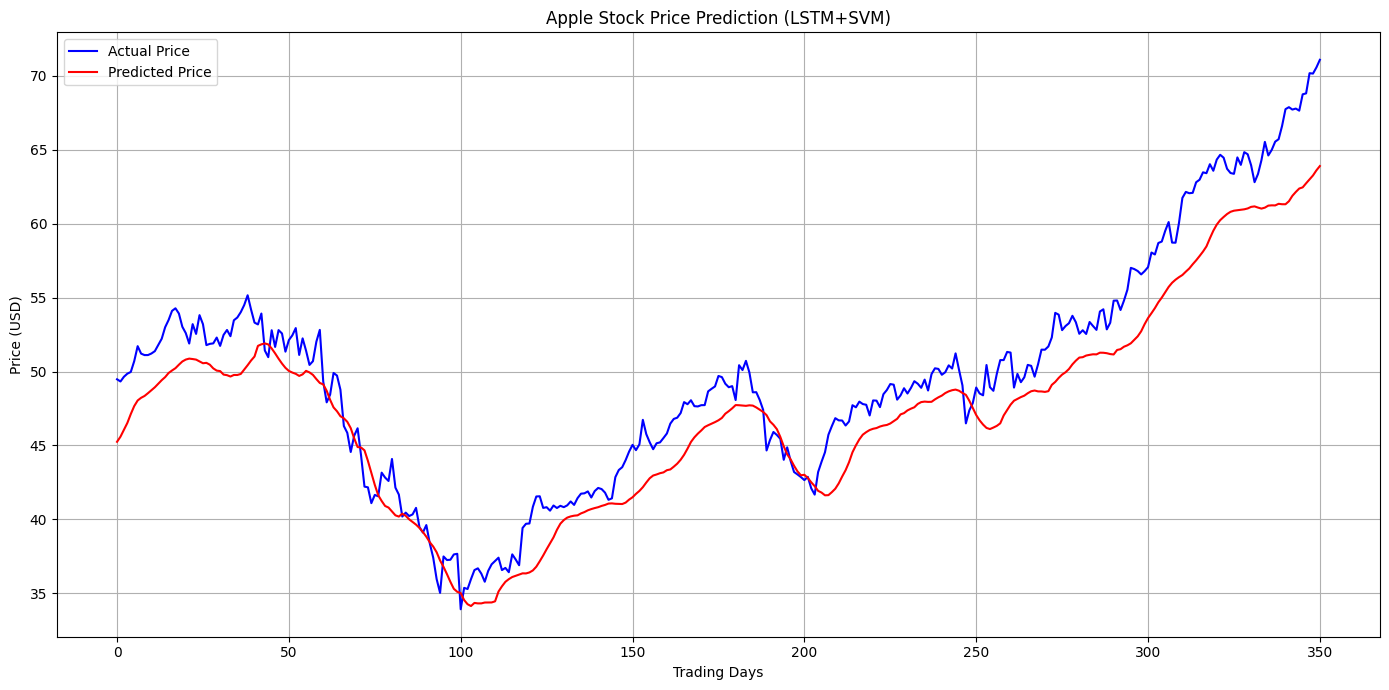

In [ ]:
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(y_test_denorm, label='Actual Price', color='blue')
plt.plot(lstm_svm_predictions_denorm, label='Predicted Price', color='red')
plt.title('Apple Stock Price Prediction (LSTM+SVM)')
plt.xlabel('Trading Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Sample of results:
        Date     Actual  Predicted  Actual_Movement  Predicted_Movement
0 2018-08-09  49.475447  45.246416                0                   0
1 2018-08-10  49.328085  45.592278                0                   1
2 2018-08-13  49.646584  46.053739                1                   1
3 2018-08-14  49.855752  46.522681                1                   1
4 2018-08-15  49.972224  47.123731                1                   1


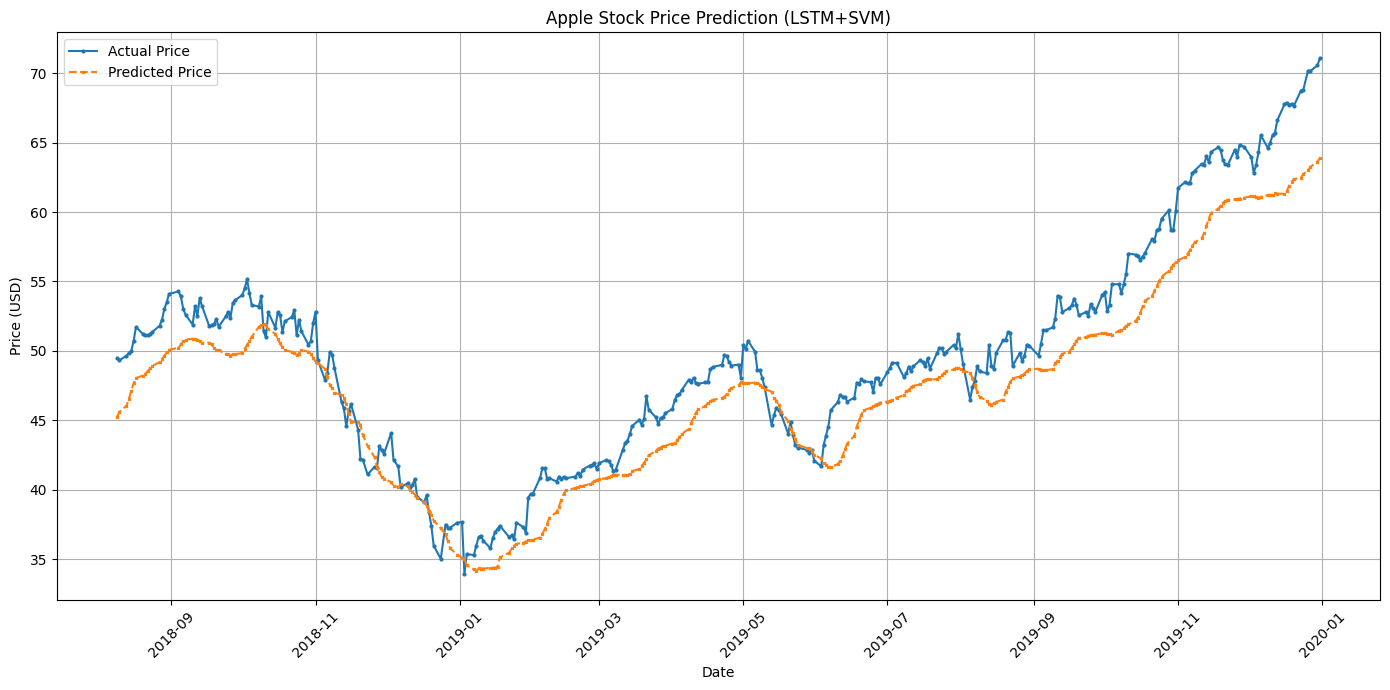


Performance Metrics Summary:
Mean Squared Error: 8.0375
Accuracy (price movement direction): 0.5584
F1 Score (price movement direction): 0.6353
R2 Score: 0.8689


In [ ]:
# Get actual dates for the test set
test_dates = data.index[split_idx + seq_length:].tolist()

# Create a DataFrame with results
results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': y_test_denorm,
    'Predicted': lstm_svm_predictions_denorm,
    'Actual_Movement': y_test_movement,
    'Predicted_Movement': pred_movement
})

print("\nSample of results:")
print(results_df.head())

# Additional plot showing actual vs predicted with dates
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_denorm, label='Actual Price', marker='o', linestyle='-', markersize=2)
plt.plot(test_dates, lstm_svm_predictions_denorm, label='Predicted Price', marker='x', linestyle='--', markersize=2)
plt.title('Apple Stock Price Prediction (LSTM+SVM)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the final metrics summary
print("\nPerformance Metrics Summary:")
print(f'Mean Squared Error: {mse:.4f}')
print(f'Accuracy (price movement direction): {accuracy:.4f}')
print(f'F1 Score (price movement direction): {f1:.4f}')
print(f'R2 Score: {r_2:.4f}')

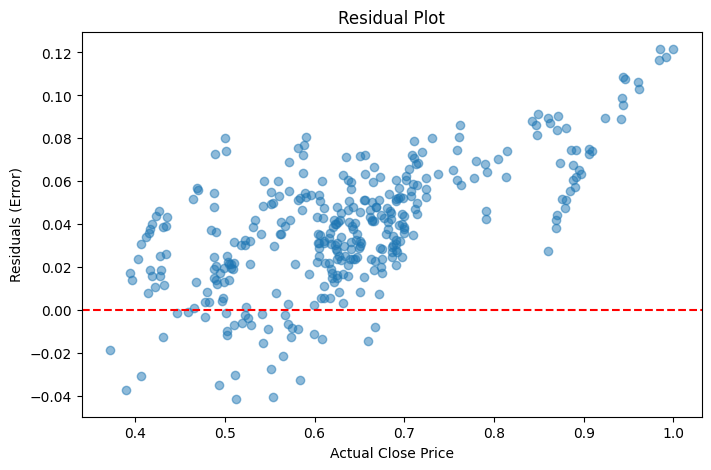

In [ ]:
plt.figure(figsize=(8, 5))
# Replace 'predictions' with 'lstm_svm_predictions_test' to get the model predictions
residuals = y_test.numpy() - lstm_svm_predictions_test
plt.scatter(y_test.numpy(), residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')  # Add a reference line at 0
plt.xlabel("Actual Close Price")
plt.ylabel("Residuals (Error)")
plt.title("Residual Plot")
plt.show()

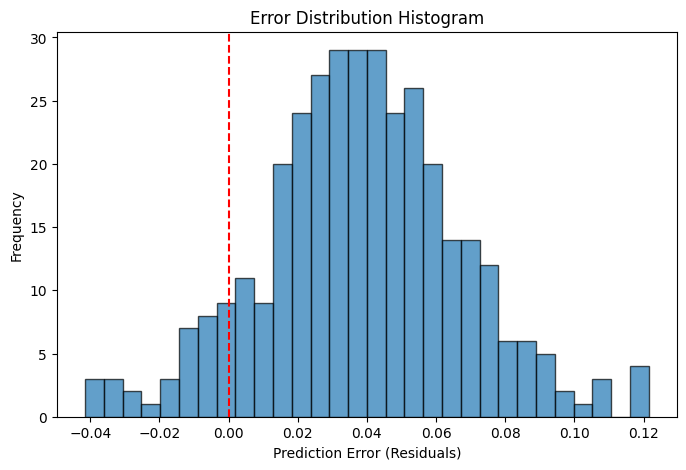

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')  # Reference line at zero
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.title("Error Distribution Histogram")
plt.show()


In [ ]:
train_losses = []
val_losses = []

epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    train_loss = criterion(output.squeeze(), y_train)
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())  # Store training loss

    # Validation Loss (without gradient tracking)
    model.eval()
    with torch.no_grad():
        val_output = model(X_test)
        val_loss = criterion(val_output.squeeze(), y_test)
        val_losses.append(val_loss.item())  # Store validation loss

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss.item():.6f}, Val Loss: {val_loss.item():.6f}")


Epoch 10, Train Loss: 0.000420, Val Loss: 0.000839
Epoch 20, Train Loss: 0.000369, Val Loss: 0.000791
Epoch 30, Train Loss: 0.000324, Val Loss: 0.000689
Epoch 40, Train Loss: 0.000284, Val Loss: 0.000690
Epoch 50, Train Loss: 0.000253, Val Loss: 0.000722


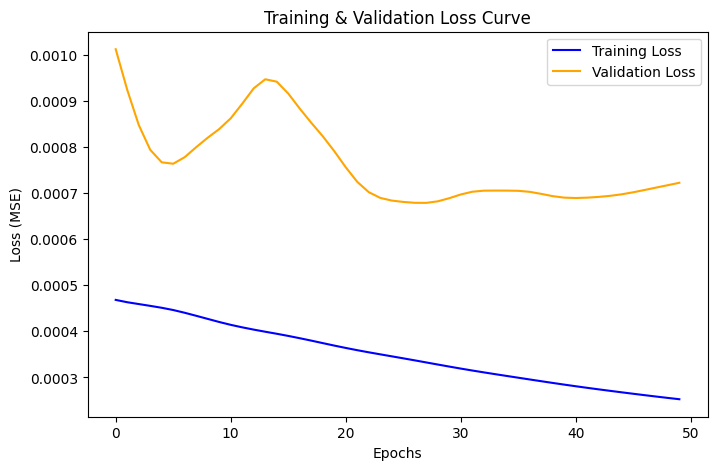

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", color='blue')
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()
